# Model validation

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local
gpu [cuda(id=0)]


## Render model

2023-12-18 14:00:26.962874: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


model_kwargs={'mesh_size': array([64, 64, 64]), 'box_size': array([640, 640, 640]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': True}
cell_lengths=[10.0, 10.0, 10.0] Mpc/h
k_nyquist=0.31416 h/Mpc, delta_k=0.00982 h/Mpc
mean_galaxy_cell_intensity=1.000 galaxy/cell


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **

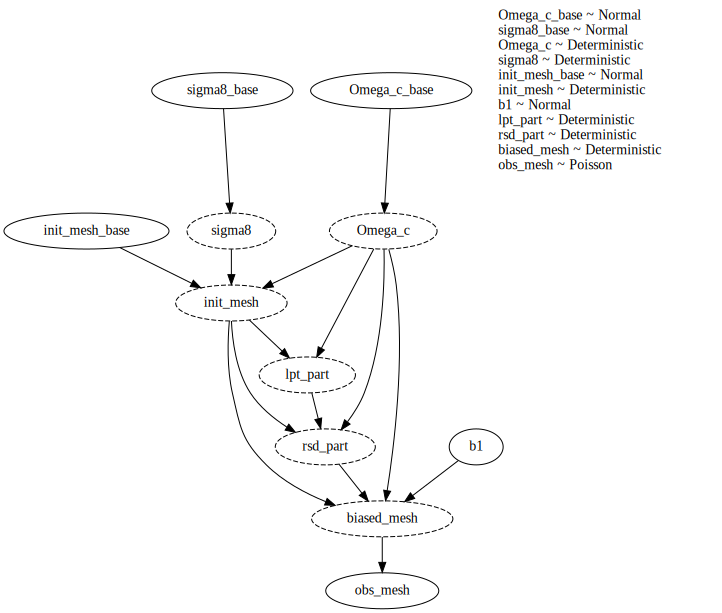

In [2]:
from montecosmo.models import forward_model, model_kwargs
model_kwargs['trace_deterministic'] = True
model_kwargs['scale_factor_lpt'] = 0.5
model_kwargs['scale_factor_obs'] = 0.5
# model_kwargs['mesh_size'] = np.array([8,8,8])
print(f"{model_kwargs=}")

# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

## Simulate fiducial

In [3]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)

# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
from jax_cosmo import Planck15
fiducial_cosmology = Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


# Pk test

In [31]:
from jaxpm.kernels import fftk
from scipy.special import legendre

def _my_initialize_pk(mesh_size, box_size, kmin, dk, los):

    W = np.empty(mesh_size, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0

    kmax = np.pi * np.min(np.array(mesh_size)) / np.max(np.array(box_size)) + dk / 2
    kedges = np.arange(kmin, kmax, dk)

    kshapes = np.eye(len(mesh_size), dtype='int') * -2 + 1
    kvec = [2 * np.pi *np.fft.fftfreq(m, l / m).reshape(kshape)
            for m, l, kshape in zip(mesh_size, box_size, kshapes)]
    kmesh = sum(ki**2 for ki in kvec)**0.5

    dig = np.digitize(kmesh.reshape(-1), kedges)
    Nsum = np.bincount(dig, weights=W.reshape(-1), minlength=len(kedges)+1)

    Nsum2, bin_edges = np.histogram(kmesh.reshape(-1), bins=kedges, weights=W.reshape(-1))
    print(bin_edges.shape, kedges.shape) # XXX: do with Rfftn?
    print(Nsum.shape, Nsum2.shape)

    mumesh = sum(ki*losi for ki, losi in zip(kvec, los))
    kmesh[kmesh == 0] = jnp.inf # modify kmesh, so ensure digitizing kmesh before this
    mumesh = mumesh / kmesh

    return dig, Nsum, W, kedges, mumesh


def my_power_spectrum(field, kmin, dk, box_size, los=jnp.array([0,0,1]), multipoles=0):
    # Initialize values related to powerspectra (mode bins and weights)
    multipoles = jnp.atleast_1d(multipoles)
    mesh_size = field.shape
    dig, Nsum, W, kedges, mumesh = _my_initialize_pk(mesh_size, box_size, kmin, dk, los)

    # Absolute value of FFT
    fft_image = jnp.fft.fftn(field)
    pk = jnp.real(fft_image * jnp.conj(fft_image)) # XXX: if real then why imag?

    # Calculating powerspectra
    imag = jnp.imag(pk)
    real = jnp.real(pk)
    Psum = np.empty((len(multipoles), *Nsum.shape))
    for i_ell, ell in enumerate(multipoles):
        imag_weights = W * imag * legendre(ell)(mumesh)
        real_weights = W * real * legendre(ell)(mumesh)
        Psum[i_ell] = jnp.bincount(dig, weights=imag_weights.reshape(-1), length=kedges.size+1) * 1j
        Psum[i_ell]+= jnp.bincount(dig, weights=real_weights.reshape(-1), length=kedges.size+1)

    # Normalization for powerspectra
    P = (Psum / Nsum)[:,1:-1] * np.prod(box_size) # XXX: why not square?
    norm = np.prod(mesh_size)**2

    # Find central values of each bin
    kbins = kedges[:-1] + (kedges[1:] - kedges[:-1]) / 2

    return kbins, P / norm

In [6]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get meshes from model trace
init_mesh = fiducial_model_trace['init_mesh']['value']
biased_mesh = fiducial_model_trace['biased_mesh']['value']
obs_mesh = fiducial_model_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_model_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_model_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, a=model_kwargs['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, a=model_kwargs['scale_factor_obs'])

multipoles = [0, 2, 4]
pk_init = my_power_spectrum(init_mesh, kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipoles=multipoles)
pk_lpt = my_power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipoles=multipoles)
pk_rsd = my_power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipoles=multipoles)
pk_biased = my_power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipoles=multipoles)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


(32,) (32,)
(33,) (31,)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/array.py:377: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


(32,) (32,)
(33,) (31,)
(32,) (32,)
(33,) (31,)
(32,) (32,)
(33,) (31,)


In [24]:
import numpyro.distributions as dist
from jaxpm.kernels import fftk
from jaxpm.growth import growth_rate, growth_factor

def kaiser_bias(cosmo, a, mesh_size, box_size, los):
    b = numpyro.sample('b', dist.Normal(2, 0.25))
    a = jnp.atleast_1d(a)

    kvec = fftk(mesh_size)
    kmesh = sum((kk  * (m / l))**2 for kk, m, l in zip(kvec, mesh_size, box_size))**0.5
    mumesh = sum(ki*losi for ki, losi in zip(kvec, los))
    kmesh[kmesh == 0] = jnp.inf
    mumesh = mumesh / kmesh

    return b + growth_rate(cosmo, a) * mumesh**2

def apply_kaiser_bias(cosmo, a, init_mesh, box_size, los=jnp.array([0,0,1])):
    # Get init_mesh at observation scale factor
    a = jnp.atleast_1d(a)
    init_mesh = init_mesh * growth_factor(cosmo, a)

    # Apply eulerian kaiser bias weights
    kaiser_weights = kaiser_bias(cosmo, a, init_mesh.shape, box_size, los)
    delta_k = jnp.fft.rfftn(init_mesh)
    kaiser_mesh = jnp.fft.irfftn(kaiser_weights * delta_k)
    return kaiser_mesh

fiducial_eulerian_bias = condition(apply_kaiser_bias, {'b': 1 + fiducial_model_trace['b1']['value']})
kaiser_mesh = fiducial_eulerian_bias(fiducial_cosmology, model_kwargs['scale_factor_obs'], init_mesh, model_kwargs['box_size'])
pk_kaiser = my_power_spectrum(kaiser_mesh, kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipoles=multipoles)

(32,) (32,)
(33,) (31,)


In [25]:
def kaiser_power_spectrum(cosmo, a, pk_init, bias, multipoles=0):
    multipoles = jnp.atleast_1d(multipoles)
    a = jnp.atleast_1d(a)
    f = growth_rate(cosmo, a)

    pk = np.empty((len(multipoles), *pk_init.shape))
    for i_ell, ell in enumerate(multipoles):
        if ell==0:
            pk[i_ell] = 2*bias**2*pk_init + 4*bias*pk_init/3 + 2*f**2*pk_init/5

        elif ell==2:
            pk[i_ell] = 8/105 * f * pk_init * (7*bias + 3*f)

        elif ell==4:
            pk[i_ell] = 16/315 * f**2 * pk_init

        else: raise Exception("Handle only multipoles of order 0, 2 ,4") 
    return pk

pk_kaiser_th = pk_init[0], kaiser_power_spectrum(fiducial_cosmology, model_kwargs['scale_factor_obs'], pk_lin_init(pk_init[0]), 1+fiducial_model_trace['b1']['value'], multipoles)

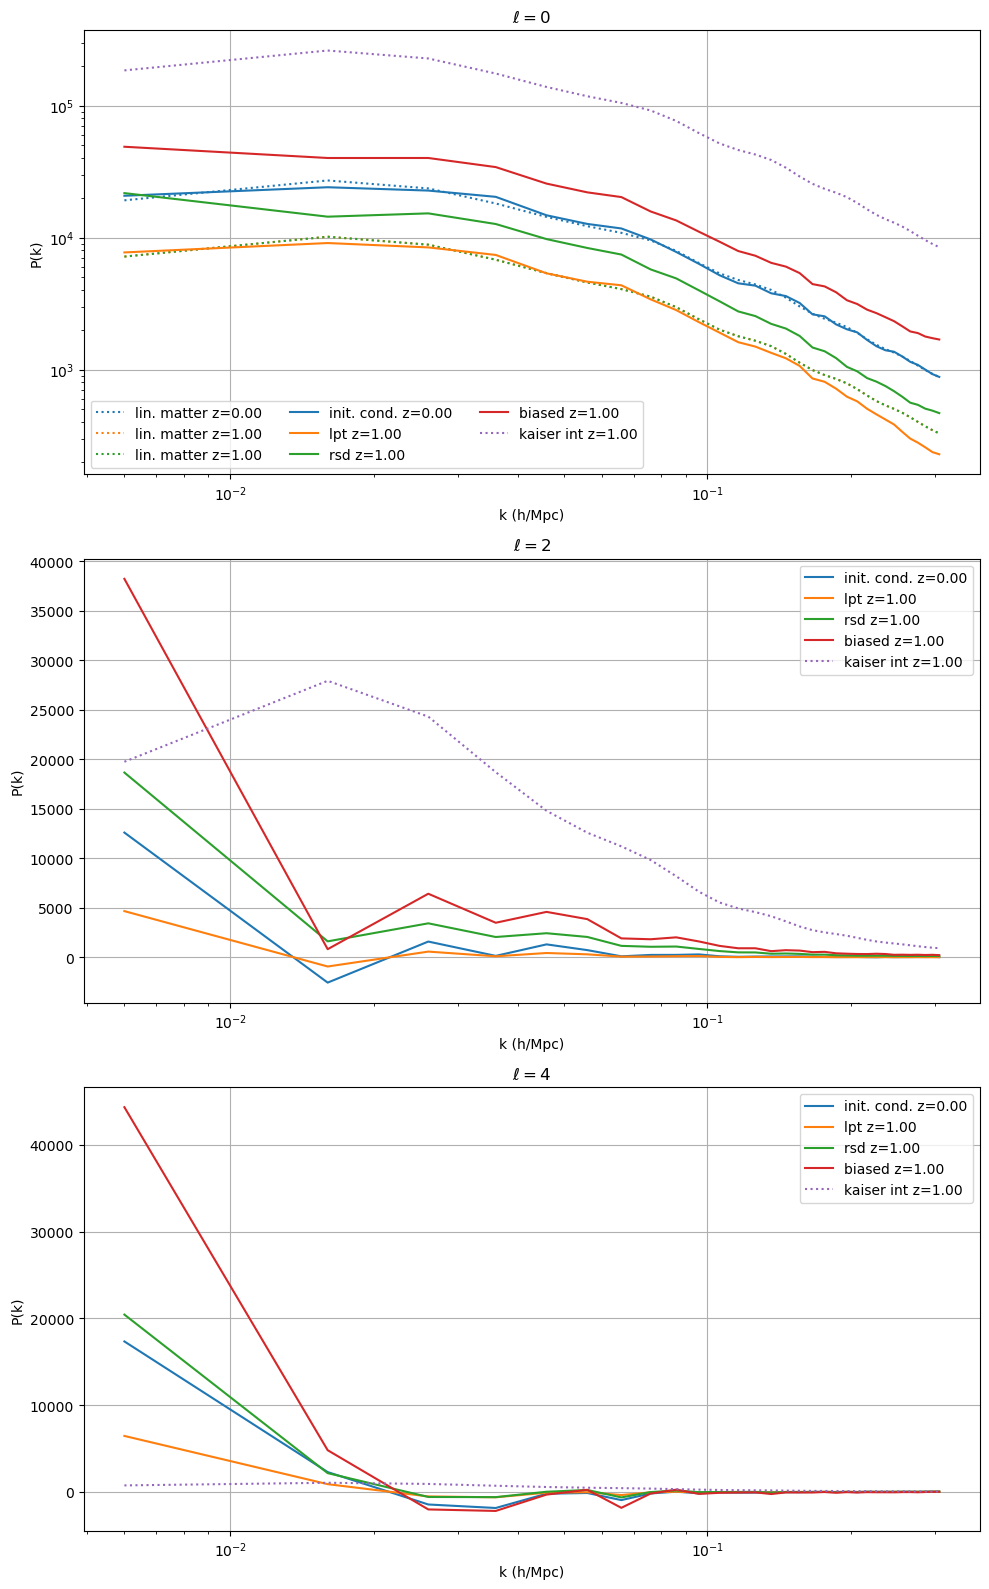

In [29]:
plt.figure(figsize=(10,16))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)

    if multipole==0:
        plot_fn = plt.loglog
        plot_fn(pk_init[0], pk_lin_init(pk_init[0]), 'C0:', label=f"lin. matter z={1/1-1:.2f}")
        plot_fn(pk_init[0], pk_lin_lpt(pk_init[0]), 'C1:', label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
        plot_fn(pk_init[0], pk_lin_obs(pk_init[0]), 'C2:', label=f"lin. matter z={1/model_kwargs['scale_factor_obs']-1:.2f}")
    else:
        plot_fn = plt.semilogx

    plot_fn(pk_init[0], pk_init[1][i_pole], 'C0', label=f"init. cond. z={1/1-1:.2f}")
    plot_fn(pk_lpt[0], pk_lpt[1][i_pole], 'C1', label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
    plot_fn(pk_rsd[0], pk_rsd[1][i_pole], 'C2', label=f"rsd z={1/model_kwargs['scale_factor_obs']-1:.2f}")
    plot_fn(pk_biased[0], pk_biased[1][i_pole], 'C3', label=f"biased z={1/model_kwargs['scale_factor_obs']-1:.2f}")

    plot_fn(pk_kaiser_th[0], pk_kaiser_th[1][i_pole], 'C4:', label=f"kaiser int z={1/model_kwargs['scale_factor_obs']-1:.2f}")
    # plot_fn(pk_kaiser[0], pk_kaiser[1][i_pole], 'C4', label=f"kaiser sim z={1/model_kwargs['scale_factor_obs']-1:.2f}")

    if multipole==0:
        plt.legend(ncols=3)
    else:
        plt.legend()
    
    plt.grid(), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)"), plt.title(rf"$\ell={multipole}$")
plt.tight_layout(), plt.show();

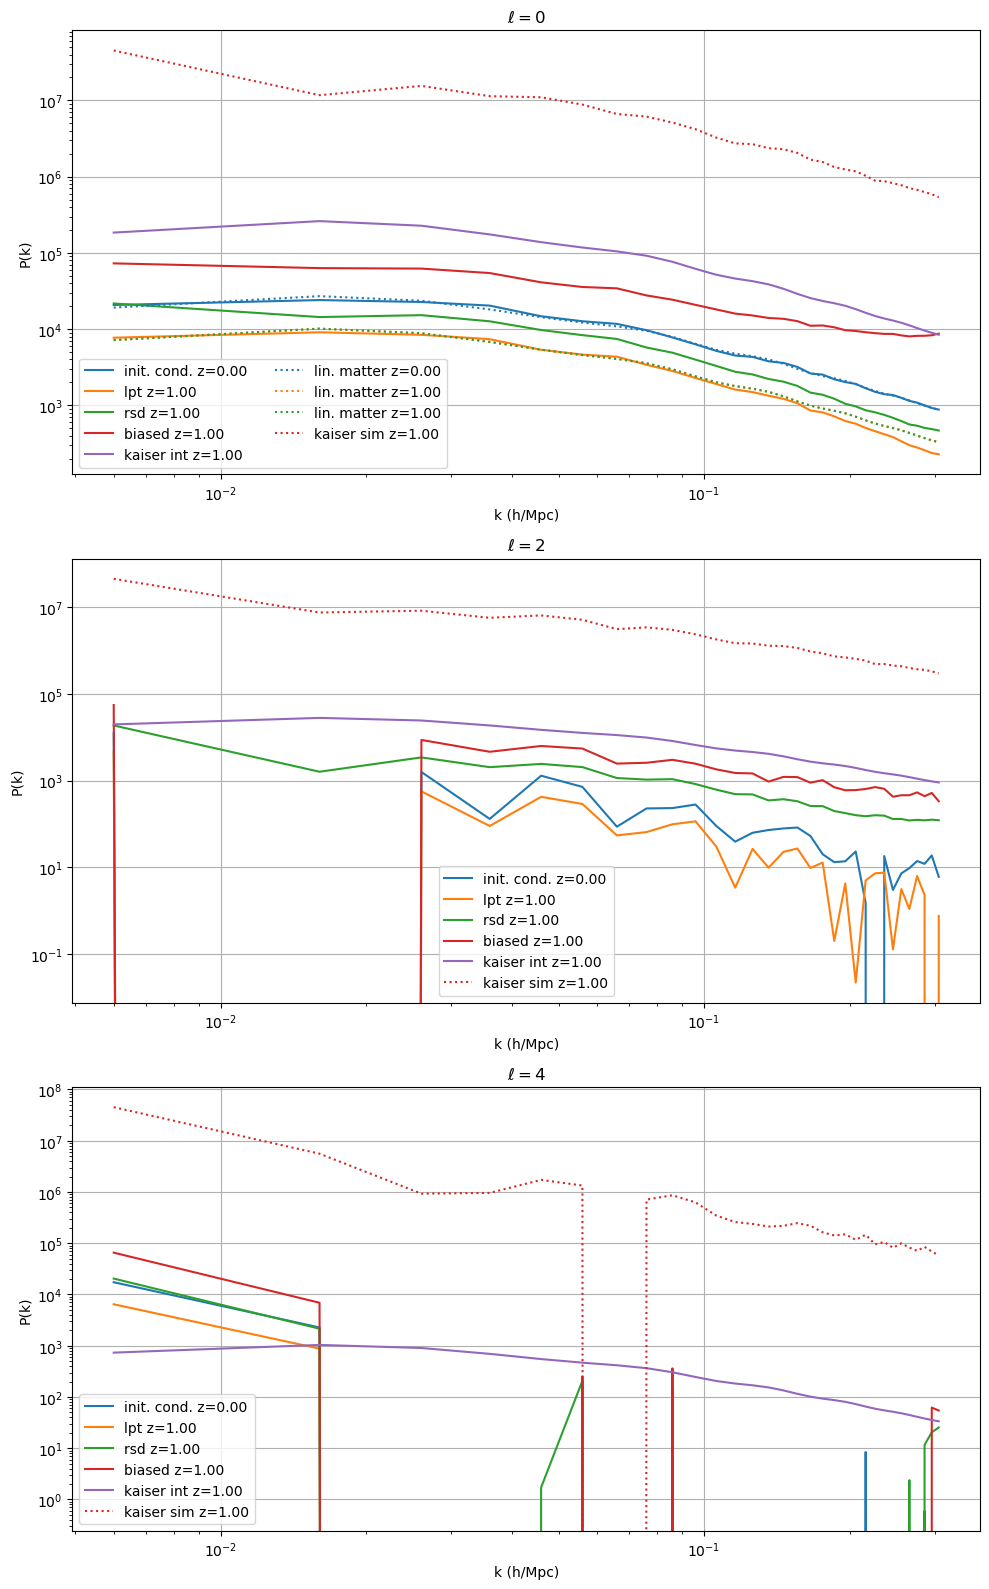

In [ ]:
plt.figure(figsize=(10,16))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)

    plt.loglog(pk_init[0], pk_init[1][i_pole], 'C0', label=f"init. cond. z={1/1-1:.2f}")
    plt.loglog(pk_lpt[0], pk_lpt[1][i_pole], 'C1', label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
    plt.loglog(pk_rsd[0], pk_rsd[1][i_pole], 'C2', label=f"rsd z={1/model_kwargs['scale_factor_obs']-1:.2f}")
    plt.loglog(pk_biased[0], pk_biased[1][i_pole], 'C3', label=f"biased z={1/model_kwargs['scale_factor_obs']-1:.2f}")
    plt.loglog(pk_kaiser_th[0], pk_kaiser_th[1][i_pole], 'C4', label=f"kaiser int z={1/model_kwargs['scale_factor_obs']-1:.2f}")

    if multipole==0:
        plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), 'C0:', label=f"lin. matter z={1/1-1:.2f}")
        plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), 'C1:', label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
        plt.loglog(pk_init[0], pk_lin_obs(pk_init[0]), 'C2:', label=f"lin. matter z={1/model_kwargs['scale_factor_obs']-1:.2f}")
    plt.loglog(pk_kaiser[0], pk_kaiser[1][i_pole], 'C3:', label=f"kaiser sim z={1/model_kwargs['scale_factor_obs']-1:.2f}")
    if multipole==0:
        plt.legend(ncols=2)
    else:
        plt.legend()
    
    plt.grid(), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)"), plt.title(rf"$\ell={multipole}$")
plt.tight_layout(), plt.show();

## Power spectra

In [7]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get meshes from model trace
init_mesh = fiducial_model_trace['init_mesh']['value']
biased_mesh = fiducial_model_trace['biased_mesh']['value']
obs_mesh = fiducial_model_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_model_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_model_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_obs'])

pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_lpt = power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_rsd = power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_biased = power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


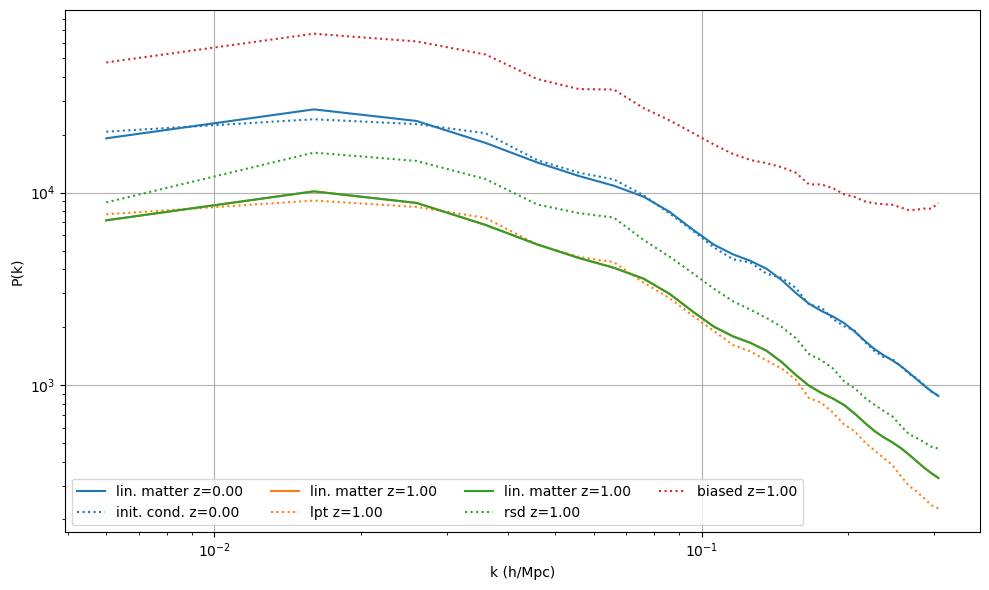

In [ ]:
plt.figure(figsize=(10,6))
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), 'C0', label=f"lin. matter z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_init[1], 'C0:', label=f"init. cond. z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), 'C1', label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_lpt[0], pk_lpt[1], 'C1:', label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_init[0], pk_lin_obs(pk_init[0]), 'C2', label=f"lin. matter z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_rsd[0], pk_rsd[1], 'C2:', label=f"rsd z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_biased[0], pk_biased[1], 'C3:', label=f"biased z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.grid(), plt.legend(ncols=4), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.tight_layout(), plt.show();

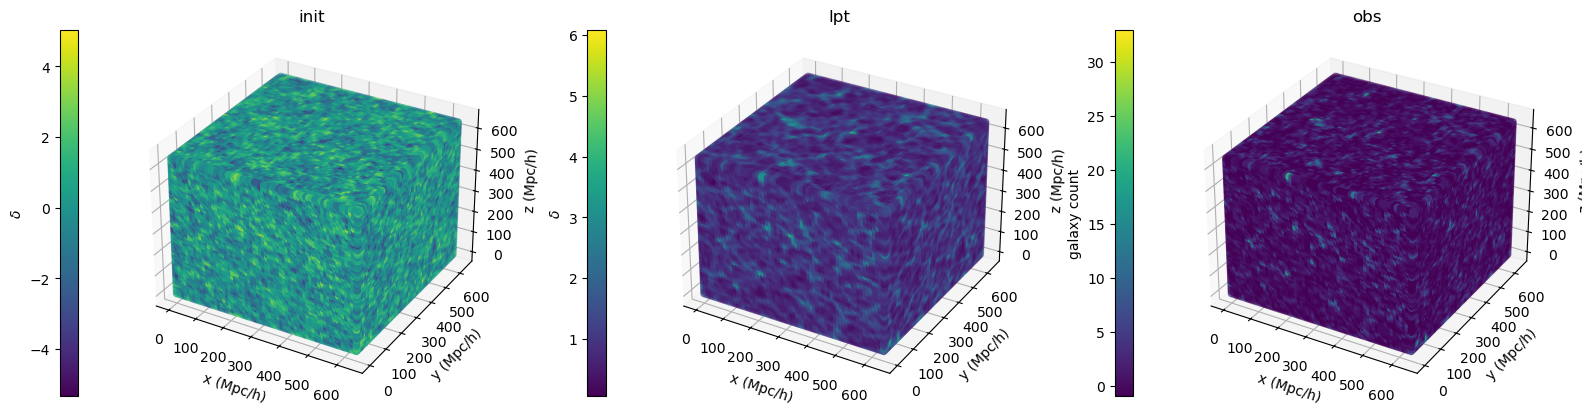

In [7]:
plt.figure(figsize=(16,4))
# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(131, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("init")

ax3D = plt.subplot(132, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(133, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=obs_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("obs")
# ax3D.set_box_aspect(None, zoom=0.8)

plt.tight_layout(), plt.show();

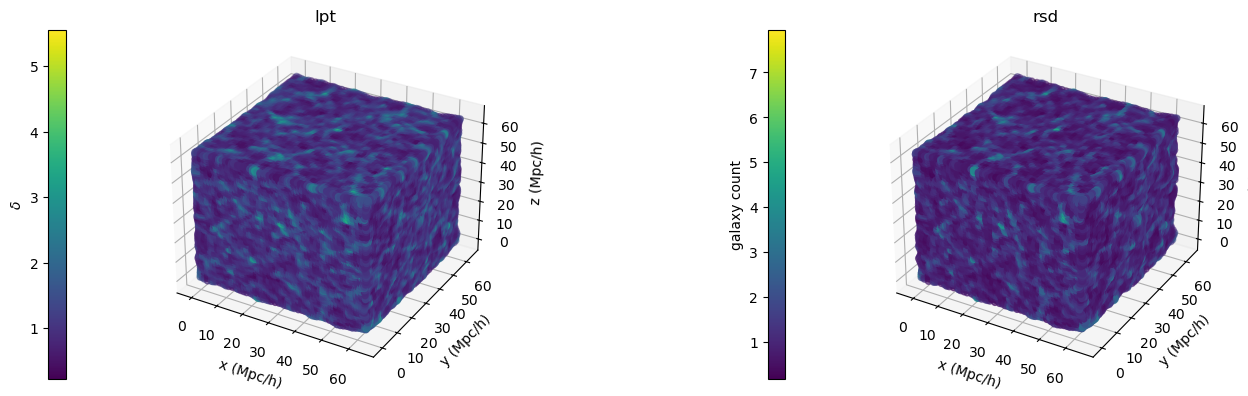

In [8]:
%matplotlib inline
plt.figure(figsize=(16,4))
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(121, projection='3d')
pos = fiducial_model_trace['lpt_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(lpt_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(122, projection='3d')
pos = fiducial_model_trace['rsd_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(rsd_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("rsd")

plt.tight_layout(), plt.show();